<a href="https://colab.research.google.com/github/alexsuakim/Natural-Language-Processing/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentimental analysis on the corpus ***twitter_samples*** from nltk library.

### Load the data to your workspace and print out all the file ids


inside twitter_samples. Put all the libraries or packages you would need to use in this assignment here.

In [ ]:
#!pip install wordcloud
#!pip install --upgrade gensim
#!pip install notebook --upgrade
#file path
#"C:\Users\Sua\Documents\GoogleNews-vectors-negative300.bin.gz"

#unzip gz file
#with gzip.open(r"C:\Users\Sua\Documents\GoogleNews-vectors-negative300.bin.gz", 'rb') as f_in:
    #with open('GoogleNews-vectors-negative300.bin', 'wb') as f_out:
        #shutil.copyfileobj(f_in, f_out)


In [ ]:
# some sample libraries are provided here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim
import os
import gzip
import shutil
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

print(twitter_samples.fileids())

# print out the file ids

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']


### Load the negative and positive tweets file to a dataframe with column names {tweet, sentiment} and assign label as 0 for negative, 1 for positive. Print the first 3 rows of your dataframe.

In [ ]:
#size of positive_tweets and negative_tweets
x = len(twitter_samples.strings('positive_tweets.json')) #5000
y = len(twitter_samples.strings('negative_tweets.json')) #5000

#add tweets together
tweet = twitter_samples.strings('positive_tweets.json') +twitter_samples.strings('negative_tweets.json')

#add sentiments together
pos = np.ones(x)
neg = np.zeros(y)
sentiment = np.concatenate((pos, neg))

#create dataframe
d = {'tweet':tweet,'sentiment':sentiment}
your_dataframe = pd.DataFrame(data=d)

#show dataframe
your_dataframe.head(3)

,tweet,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1.0
1,@Lamb2ja Hey James! How odd :/ Please call our...,1.0
2,@DespiteOfficial we had a listen last night :)...,1.0


### Visualize and comment on the data balance of this dataset.

<AxesSubplot:xlabel='sentiment'>

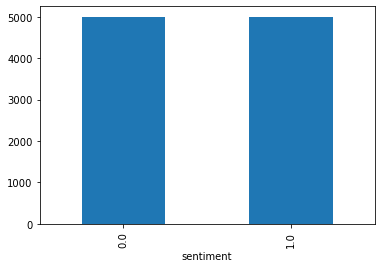

In [ ]:
# visualization
df_count = your_dataframe.groupby('sentiment')['tweet'].count()
df_count.plot(kind = 'bar')

Your comment here: A balanced dataset is a dataset in which each output class has the same number of inputs. In this case, as we can see from the above bar plot, both the output classes 0 and 1 have the same number of imputs, which is 5,000. Thus, we can say that the dataset is balanced.



#  Text Preprocessing

### The original tweets might be noisy, containing lots of elements that cause mess. Please think of what preprocessing procedure is needed for this specific dataset, and more important, what is the correct order between these steps. The below functions are the ones I think quite important for the data. Please fill in the function defintion, design more functions (if you want) and apply them in the order you decide. The text after processed should be save in a new column named **tidy_tweet**. Please clearly explain the reason you want to add this function, and why you would like to arrange the order like this. For each function, you need to print out the difference before and after the approach by showing the columns {tweet, tidy_tweet} side by side.


Explain the functions:
1. The function 'remove_pattern' deletes the words that start with @ and #. Words that start with @ are usually IDs that don't contain any meaning. Words that start with # are hashtags that usually denotes special terms and are badly spaced, so it is difficult to grab any meaning from them.

Why I have arranged the functions in this order:
1. I have applied the 'emoticons_to_word' function first because many of the values in 'Emoticon_Dictionary' start with an uppercase letter. Many of the keys in 'Emoticon_Dictionary' also starts with an uppercase letter so it should come before 'convert_to_lowercase'.
2. I have applied the 'convert_to_lowercase' function next becase a lot of functions, including remove_stopwords require all the texts to be in lowercase.
3. the functions 'emoji_to_word', 'remove_urls', 'remove_pattern' are applied in the middle because they merely get rid of the words they address.
4. the function 'remove_stopwords' comes second to last to get rid of all the stopwords. Stopwords include the stopwords that could have been added from the 'emoticons_to_word' function.
5. the 'remove_punctuation' function should come very last. If it doesn't come last, it might remove important punctuations used in 'emoticons_to_word', 'remove_urls', and 'remove_pattern'.

In [ ]:
def convert_to_lowercase(tweet):
    '''
    aim: change all tweets to lower case
    '''
    tweet = tweet.lower()
    return tweet

def emoji_to_word(tweet):
    '''
    aim: remove all the emoji in the tweets
    '''
    emoji = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\u2600-\u2B55"          #more emojis
                      "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)
    return tweet

def emoticons_to_word(tweet):
    '''
    aim: based on the emoticon dictionary, replace all the emoticons to corresponding word
    The emoticon dictionary is provided in the next block
    '''
    res = ''
    for word in tweet.split():
        for emoj in Emoticon_Dictionary:
            if (re.match(emoj, word)):
                word = Emoticon_Dictionary[emoj]
        res = ' '.join([res, word])
    tweet = res
    return tweet

def remove_pattern(tweet, pattern):
    '''
    aim: remove all the "@users" appears in the tweets
    '''
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r'#\S+', '', tweet)
    return tweet

def remove_punctuation(tweet):
    '''
    aim: remove all the punctuation from the tweet given
    Punctuations are characters other than alphaters and digits.
    '''
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

def remove_stopwords(tweet):
    '''
    aim: remove all stopwords in the tweets
    '''
    tweet = ' '.join([word for word in tweet.split() if not word in stopwords.words("english")]) #tweet should be changed to lowercase first
    return tweet

def remove_urls(tweet):
    '''
    aim: remove all the urls contained inside the tweets
    '''
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

In [ ]:
Emoticon_Dictionary = {
    u":‑\)":"smiley",
    u":\)":"smiley",
    u":-\]":"smiley",
    u":\]":"smiley",
    u":-3":"smiley",
    u":3":"smiley",
    u":->":"smiley",
    u":>":"smiley",
    u"8-\)":"smiley",
    u":o\)":"smiley",
    u":-\}":"smiley",
    u":\}":"smiley",
    u":-\)":"smiley",
    u":c\)":"smiley",
    u":\^\)":"smiley",
    u"=\]":"smiley",
    u"=\)":"smiley",
    u":‑D":"Laughing",
    u":D":"Laughing",
    u"8‑D":"Laughing",
    u"8D":"Laughing",
    u"X‑D":"Laughing",
    u"XD":"Laughing",
    u"=D":"Laughing",
    u"=3":"Laughing",
    u"B\^D":"Laughing",
    u":-\)\)":"happy",
    u":‑\(":"sad",
    u":-\(":"sad",
    u":\(":"sad",
    u":‑c":"sad",
    u":c":"sad",
    u":‑<":"sad",
    u":<":"sad",
    u":‑\[":"sad",
    u":\[":"sad",
    u":-\|\|":"sad",
    u">:\[":"sad",
    u":\{":"sad",
    u":@":"sad",
    u">:\(":"sad",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"happiness",
    u":'\)":"happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"dismay",
    u"D;":"dismay",
    u"D=":"dismay",
    u"DX":"dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"smirk",
    u";\)":"smirk",
    u"\*-\)":"smirk",
    u"\*\)":"smirk",
    u";‑\]":"smirk",
    u";\]":"smirk",
    u";\^\)":"smirk",
    u":‑,":"smirk",
    u";D":"smirk",
    u":‑P":"playful",
    u":P":"playful",
    u"X‑P":"playful",
    u"XP":"playful",
    u":‑Þ":"playful",
    u":Þ":"playful",
    u":b":"playful",
    u"d:":"playful",
    u"=p":"playful",
    u">:P":"playful",
    u":‑/":"annoyed",
    u":/":"annoyed",
    u":-[.]":"annoyed",
    u">:[(\\\)]":"annoyed",
    u">:/":"annoyed",
    u":[(\\\)]":"annoyed",
    u"=/":"annoyed",
    u"=[(\\\)]":"annoyed",
    u":L":"annoyed",
    u"=L":"annoyed",
    u":S":"annoyed",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed",
    u":‑x":"tongue-tied",
    u":x":"tongue-tied",
    u":‑#":"tongue-tied",
    u":#":"tongue-tied",
    u":‑&":"tongue-tied",
    u":&":"tongue-tied",
    u"O:‑\)":"innocent",
    u"O:\)":"innocent",
    u"0:‑3":"innocent",
    u"0:3":"innocent",
    u"0:‑\)":"innocent",
    u"0:\)":"innocent",
    u":‑b":"cheeky",
    u"0;\^\)":"innocent",
    u">:‑\)":"Evil",
    u">:\)":"Evil",
    u"\}:‑\)":"Evil",
    u"\}:\)":"Evil",
    u"3:‑\)":"Evil",
    u"3:\)":"Evil",
    u">;\)":"Evil",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party",
    u"%‑\)":"confused",
    u"%\)":"confused",
    u":-###..":"sick",
    u":###..":"sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous",
    u"\(\^_\^;\)":"Nervous",
    u"\(-_-;\)":"Nervous",
    u"\(~_~;\) \(・\.・;\)":"Nervous",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"respect",
    u"_\(\._\.\)_":"respect",
    u"<\(_ _\)>":"respect",
    u"<m\(__\)m>":"respect",
    u"m\(__\)m":"respect",
    u"m\(_ _\)m":"respect",
    u"\('_'\)":"Sad",
    u"\(/_;\)":"Sad",
    u"\(T_T\) \(;_;\)":"Sad",
    u"\(;_;":"Sad",
    u"\(;_:\)":"Sad",
    u"\(;O;\)":"Sad",
    u"\(:_;\)":"Sad",
    u"\(ToT\)":"Sad",
    u";_;":"Sad",
    u";-;":"Sad",
    u";n;":"Sad",
    u";;":"Sad",
    u"Q\.Q":"Sad",
    u"T\.T":"Sad",
    u"QQ":"Sad",
    u"Q_Q":"Sad",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Laugh",
    u"<\^!\^>":"Laugh",
    u"\^/\^":"Laugh",
    u"\（\*\^_\^\*）" :"Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Laugh",
    u"\(^\^\)":"Laugh",
    u"\(\^\.\^\)":"Laugh",
    u"\(\^_\^\.\)":"Laugh",
    u"\(\^_\^\)":"Laugh",
    u"\(\^\^\)":"Laugh",
    u"\(\^J\^\)":"Laugh",
    u"\(\*\^\.\^\*\)":"Laugh",
    u"\(\^—\^\）":"Laugh",
    u"\(#\^\.\^#\)":"Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Cheerful",
    u"\(\^_\^\)v":"Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed"
}

In [ ]:
# following the order you specify above, print out columns {tweet, tidy_tweet} side by side

#add new column to dataframe
tidy_tweet = [0]*(x+y)

#apply text processing functions

#apply emoticons_to_word
print("apply emoticons_to_word")
idx = 0
for i in your_dataframe['tweet']:
    i = emoticons_to_word(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply emoticons_to_word


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#FollowFriday @France_Inte @PKuchly57 @Milipo...
1,@Lamb2ja Hey James! How odd :/ Please call our...,@Lamb2ja Hey James! How odd annoyed Please ca...
2,@DespiteOfficial we had a listen last night :)...,@DespiteOfficial we had a listen last night s...
3,@97sides CONGRATS :),@97sides CONGRATS smiley
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has...
5,@BhaktisBanter @PallaviRuhail This one is irre...,@BhaktisBanter @PallaviRuhail This one is irr...
6,We don't like to keep our lovely customers wai...,We don't like to keep our lovely customers wa...
7,"@Impatientraider On second thought, there’s ju...","@Impatientraider On second thought, there’s j..."
8,"Jgh , but we have to go to Bayan :D bye","Jgh , but we have to go to Bayan Laughing bye"
9,"As an act of mischievousness, am calling the E...","As an act of mischievousness, am calling the ..."


In [ ]:
#apply convert_to_lowercase
print("apply convert_to_lowercase")
idx = 0
for i in your_dataframe['tweet']:
    i = convert_to_lowercase(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply convert_to_lowercase


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#followfriday @france_inte @pkuchly57 @milipol...
1,@Lamb2ja Hey James! How odd :/ Please call our...,@lamb2ja hey james! how odd :/ please call our...
2,@DespiteOfficial we had a listen last night :)...,@despiteofficial we had a listen last night :)...
3,@97sides CONGRATS :),@97sides congrats :)
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has...
5,@BhaktisBanter @PallaviRuhail This one is irre...,@bhaktisbanter @pallaviruhail this one is irre...
6,We don't like to keep our lovely customers wai...,we don't like to keep our lovely customers wai...
7,"@Impatientraider On second thought, there’s ju...","@impatientraider on second thought, there’s ju..."
8,"Jgh , but we have to go to Bayan :D bye","jgh , but we have to go to bayan :d bye"
9,"As an act of mischievousness, am calling the E...","as an act of mischievousness, am calling the e..."


In [ ]:
#apply emoji_to_word
print("apply emoji_to_word")
idx = 0
for i in your_dataframe['tweet']:
    i = emoji_to_word(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply emoji_to_word


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,@Lamb2ja Hey James! How odd :/ Please call our...,@Lamb2ja Hey James! How odd :/ Please call our...
2,@DespiteOfficial we had a listen last night :)...,@DespiteOfficial we had a listen last night :)...
3,@97sides CONGRATS :),@97sides CONGRATS :)
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has...
5,@BhaktisBanter @PallaviRuhail This one is irre...,@BhaktisBanter @PallaviRuhail This one is irre...
6,We don't like to keep our lovely customers wai...,We don't like to keep our lovely customers wai...
7,"@Impatientraider On second thought, there’s ju...","@Impatientraider On second thought, there’s ju..."
8,"Jgh , but we have to go to Bayan :D bye","Jgh , but we have to go to Bayan :D bye"
9,"As an act of mischievousness, am calling the E...","As an act of mischievousness, am calling the E..."


In [ ]:
#apply remove_urls
print("apply remove_urls")
idx = 0
for i in your_dataframe['tweet']:
    i = remove_urls(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply remove_urls


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,@Lamb2ja Hey James! How odd :/ Please call our...,@Lamb2ja Hey James! How odd :/ Please call our...
2,@DespiteOfficial we had a listen last night :)...,@DespiteOfficial we had a listen last night :)...
3,@97sides CONGRATS :),@97sides CONGRATS :)
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has...
5,@BhaktisBanter @PallaviRuhail This one is irre...,@BhaktisBanter @PallaviRuhail This one is irre...
6,We don't like to keep our lovely customers wai...,We don't like to keep our lovely customers wai...
7,"@Impatientraider On second thought, there’s ju...","@Impatientraider On second thought, there’s ju..."
8,"Jgh , but we have to go to Bayan :D bye","Jgh , but we have to go to Bayan :D bye"
9,"As an act of mischievousness, am calling the E...","As an act of mischievousness, am calling the E..."


In [ ]:
#apply remove_pattern
print("apply remove_pattern")
idx = 0
for i in your_dataframe['tweet']:
    i = remove_pattern(i, idx)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply remove_pattern


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,for being top engaged members in my commun...
1,@Lamb2ja Hey James! How odd :/ Please call our...,Hey James! How odd :/ Please call our Contact...
2,@DespiteOfficial we had a listen last night :)...,we had a listen last night :) As You Bleed is...
3,@97sides CONGRATS :),CONGRATS :)
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! my accnt verified rqst has...
5,@BhaktisBanter @PallaviRuhail This one is irre...,This one is irresistible :)\n http://t.co/Eb...
6,We don't like to keep our lovely customers wai...,We don't like to keep our lovely customers wai...
7,"@Impatientraider On second thought, there’s ju...","On second thought, there’s just not enough ti..."
8,"Jgh , but we have to go to Bayan :D bye","Jgh , but we have to go to Bayan :D bye"
9,"As an act of mischievousness, am calling the E...","As an act of mischievousness, am calling the E..."


In [ ]:
#apply remove_stopwords
print("apply remove_stopwords")
idx = 0
for i in your_dataframe['tweet']:
    i = remove_stopwords(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply remove_stopwords


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,@Lamb2ja Hey James! How odd :/ Please call our...,@Lamb2ja Hey James! How odd :/ Please call Con...
2,@DespiteOfficial we had a listen last night :)...,@DespiteOfficial listen last night :) As You B...
3,@97sides CONGRATS :),@97sides CONGRATS :)
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy!!! accnt verified rqst succeed...
5,@BhaktisBanter @PallaviRuhail This one is irre...,@BhaktisBanter @PallaviRuhail This one irresis...
6,We don't like to keep our lovely customers wai...,We like keep lovely customers waiting long! We...
7,"@Impatientraider On second thought, there’s ju...","@Impatientraider On second thought, there’s en..."
8,"Jgh , but we have to go to Bayan :D bye","Jgh , go Bayan :D bye"
9,"As an act of mischievousness, am calling the E...","As act mischievousness, calling ETL layer in-h..."


In [ ]:
#apply remove_punctuation
print("apply remove_punctuation")
idx = 0
for i in your_dataframe['tweet']:
    i = remove_punctuation(i)
    tidy_tweet[idx] = i
    idx+=1
your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply remove_punctuation


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,FollowFriday France_Inte PKuchly57 Milipol_Par...
1,@Lamb2ja Hey James! How odd :/ Please call our...,Lamb2ja Hey James How odd Please call our Con...
2,@DespiteOfficial we had a listen last night :)...,DespiteOfficial we had a listen last night As...
3,@97sides CONGRATS :),97sides CONGRATS
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy my accnt verified rqst has su...
5,@BhaktisBanter @PallaviRuhail This one is irre...,BhaktisBanter PallaviRuhail This one is irresi...
6,We don't like to keep our lovely customers wai...,We dont like to keep our lovely customers wait...
7,"@Impatientraider On second thought, there’s ju...",Impatientraider On second thought theres just ...
8,"Jgh , but we have to go to Bayan :D bye",Jgh but we have to go to Bayan D bye
9,"As an act of mischievousness, am calling the E...",As an act of mischievousness am calling the ET...


In [ ]:
#apply all functions in a selected order
print("apply all functions in a selected order")
idx = 0
for i in your_dataframe['tweet']:
    i = emoticons_to_word(i) #should be applied before converting to lowercase
    i = convert_to_lowercase(i) #should be applied before remove_stopwords
    i = emoji_to_word(i) #use dictionaty Emoticon_Dictionary
    i = remove_urls(i)
    i = remove_pattern(i, idx) #remove words that follow @ and #
    i = remove_stopwords(i) #should be applied after convert_to_lowercase
    i = remove_punctuation(i) #should be applied after emoticons_to_word, remove_urls, remove_pattern
    tidy_tweet[idx] = i
    idx+=1

your_dataframe['tidy_tweet'] = tidy_tweet
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

apply all functions in a selected order


,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,top engaged members community week smiley
1,@Lamb2ja Hey James! How odd :/ Please call our...,hey james odd annoyed please call contact cent...
2,@DespiteOfficial we had a listen last night :)...,listen last night smiley bleed amazing track s...
3,@97sides CONGRATS :),congrats smiley
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy accnt verified rqst succeed go...
5,@BhaktisBanter @PallaviRuhail This one is irre...,one irresistible smiley
6,We don't like to keep our lovely customers wai...,like keep lovely customers waiting long hope e...
7,"@Impatientraider On second thought, there’s ju...",second thought theres enough time dd smiley ne...
8,"Jgh , but we have to go to Bayan :D bye",jgh go bayan laughing bye
9,"As an act of mischievousness, am calling the E...",act mischievousness calling etl layer inhouse ...


### After obtaining the clean text, we would perform stemming or lemmatization on the tweets. Fill in the defintion below and compare the difference between these two methods by creating and printing two columns {stem_tweet, lemm_tweet} side by side. State the reason why you prefer one over another. Choose the one you prefer to apply the procedure on the column {tidy_tweet}.

In [ ]:
def stemming(tweet):
    '''
    aim: perform stemming on the text
    '''
    ps = PorterStemmer()
    tweet = ' '.join([ps.stem(word) for word in tweet.split()])
    return tweet

def lemmatization(tweet):
    '''
    aim: perform lemmatization on the text
    '''
    wnl = WordNetLemmatizer()
    tweet = ' '.join([wnl.lemmatize(word, 'v') for word in tweet.split()])
    return tweet


#create new dataframe
stem_tweet = [0]*(x+y)
lemm_tweet = [0]*(x+y)
d_q2 = {'stem_tweet':stem_tweet,'lemm_tweet':lemm_tweet}
df_q2 = pd.DataFrame(data=d_q2)

#apply two functions and add results to lists
idx = 0
for i in your_dataframe['tidy_tweet']:
    stem_tweet[idx] = stemming(i)
    lemm_tweet[idx] = lemmatization(i)
    idx += 1

#update dataframe
df_q2['stem_tweet'] = stem_tweet
df_q2['lemm_tweet'] = lemm_tweet

df_q2.head(10)

,stem_tweet,lemm_tweet
0,top engag member commun week smiley,top engage members community week smiley
1,hey jame odd annoy pleas call contact centr 02...,hey jam odd annoy please call contact centre 0...
2,listen last night smiley bleed amaz track scot...,listen last night smiley bleed amaze track sco...
3,congrat smiley,congrats smiley
4,yeaaaah yippppi accnt verifi rqst succeed got ...,yeaaaah yippppy accnt verify rqst succeed get ...
5,one irresist smiley,one irresistible smiley
6,like keep love custom wait long hope enjoy hap...,like keep lovely customers wait long hope enjo...
7,second thought there enough time dd smiley new...,second think theres enough time dd smiley new ...
8,jgh go bayan laugh bye,jgh go bayan laugh bye
9,act mischiev call etl layer inhous wareh app k...,act mischievousness call etl layer inhouse war...


I would prefer to use the lemmatized texts since lemmatization gives the actual stem word. The result of stemming might not be an actual word. For example, for 'studies' and 'studying,' I would prefer lemmatization which give me the results 'study' and 'study.' The result of stemming, on the other hand, would be 'studi' and 'study,' but this is not desirable since I would want these two results to be the same stem word.

In [ ]:
#Choose the one you prefer to apply the procedure on the column {tidy_tweet}.
#from the logic above, I have chosen to use lemmatization.

#apply lemmatization
idx = 0
for i in your_dataframe['tidy_tweet']:
    tidy_tweet[idx] = lemmatization(i)
    idx += 1

#update dataframe
your_dataframe['tidy_tweet'] = tidy_tweet

#show dataframe
df = your_dataframe[['tweet', 'tidy_tweet']]
df.head(10)

,tweet,tidy_tweet
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,top engage members community week smiley
1,@Lamb2ja Hey James! How odd :/ Please call our...,hey jam odd annoy please call contact centre 0...
2,@DespiteOfficial we had a listen last night :)...,listen last night smiley bleed amaze track sco...
3,@97sides CONGRATS :),congrats smiley
4,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy accnt verify rqst succeed get ...
5,@BhaktisBanter @PallaviRuhail This one is irre...,one irresistible smiley
6,We don't like to keep our lovely customers wai...,like keep lovely customers wait long hope enjo...
7,"@Impatientraider On second thought, there’s ju...",second think theres enough time dd smiley new ...
8,"Jgh , but we have to go to Bayan :D bye",jgh go bayan laugh bye
9,"As an act of mischievousness, am calling the E...",act mischievousness call etl layer inhouse war...


### Tokenize the tweets and print out the final dataframe

In [ ]:
def tokenization(tweet):
    '''
    aim: perform tokenization on the text
    '''
    tweet = word_tokenize(tweet)
    return tweet

#create your_final_dataframe
your_final_dataframe = your_dataframe
tknd_tweet = [0]*(x+y)

#tokenisation
idx = 0
for i in your_dataframe['tidy_tweet']:
    tknd_tweet[idx] = tokenization(i)
    idx += 1

#update your_final_dataframe
your_final_dataframe['tknd_tweet'] = tknd_tweet

#show your_final_dataframe
your_final_dataframe.sample(10)

,tweet,sentiment,tidy_tweet,tknd_tweet
2946,@SpringwellLife thank you so much for having u...,1.0,thank much us be glad enjoy smiley,"[thank, much, us, be, glad, enjoy, smiley]"
9890,.@aylesburyowl @ljam185 The facade of democrac...,0.0,facade democracy drop quickly sad,"[facade, democracy, drop, quickly, sad]"
194,hey my fav nirvana song is smells like teen sp...,1.0,hey fav nirvana song smell like teen spirit ri...,"[hey, fav, nirvana, song, smell, like, teen, s..."
5437,what's wrong with me :(,0.0,whats wrong sad,"[whats, wrong, sad]"
2703,@maryammirxa @ayeeshamirza Same here :D,1.0,laugh,[laugh]
6524,@Tigress1412 I miss u so bad :(,0.0,miss u bad sad,"[miss, u, bad, sad]"
2305,"@Davealwalker Hey Dave, I'd like to help! Cou...",1.0,hey dave id like help could dm full address dr...,"[hey, dave, id, like, help, could, dm, full, a..."
2356,JDs! Laro tayo :) Tag your answers to us with ...,1.0,jds laro tayo smiley tag answer us ht smiley a...,"[jds, laro, tayo, smiley, tag, answer, us, ht,..."
9187,@tiaramescudi girl that was so quick too :(,0.0,girl quick sad,"[girl, quick, sad]"
5535,Stop playing with my feelings man :( i aint go...,0.0,stop play feel man sad aint get time that stil...,"[stop, play, feel, man, sad, aint, get, time, ..."


# Visualization



### Build and plot the wordcloud for the whole dataset, the negative tweets, and the positive tweets, respectively. Analyze if the result is reasonable. Or if you think there are strange scenarios, what is the possible reasons behind.

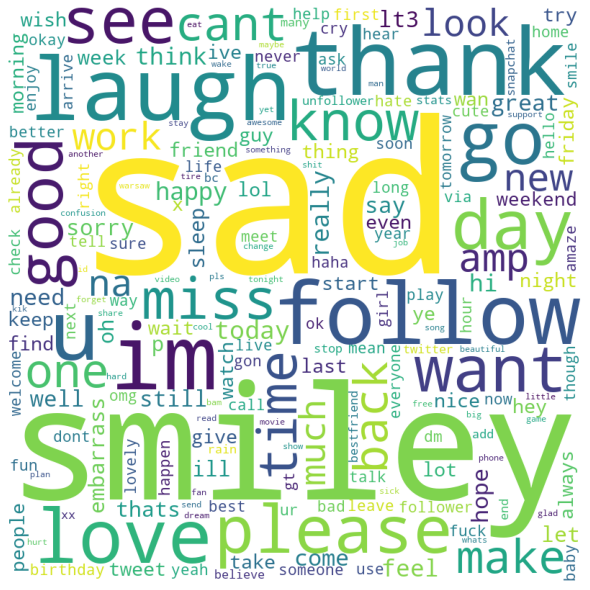

In [ ]:
# wordcloud for all
#set variables comment_words and stopwords
comment_words = ''
stopwords = set(STOPWORDS)
#generate comment_words
for tweet in your_final_dataframe['tknd_tweet']:
    for token in tweet:
        comment_words += "".join(token)+" "
# plot wordcloud
wordcloud = WordCloud(width = 800, height = 800,
                collocations = False,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

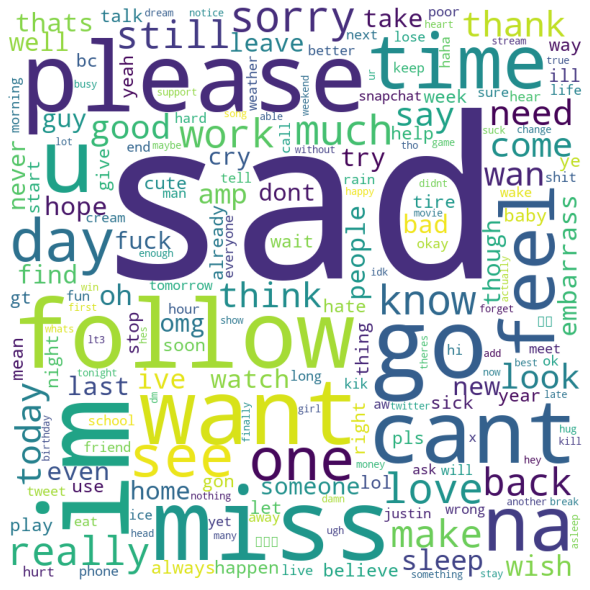

In [ ]:
# wordcloud for negative
df_neg = your_final_dataframe.loc[your_final_dataframe['sentiment'] == 0]

#set variables comment_words and stopwords
comment_words = ''
stopwords = set(STOPWORDS)
#generate comment_words
for tweet in df_neg['tknd_tweet']:
    for token in tweet:
        comment_words += "".join(token)+" "
wordcloud = WordCloud(width = 800, height = 800,
                collocations = False,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

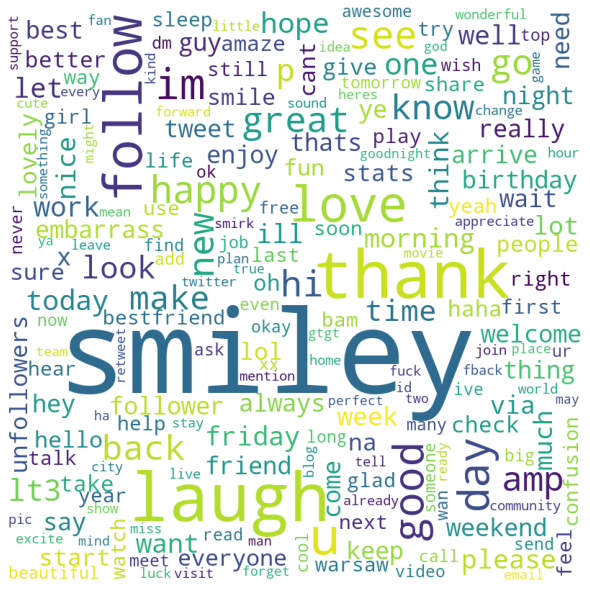

In [ ]:
# wordcloud for positive
df_pos = your_final_dataframe.loc[your_final_dataframe['sentiment'] == 1]

#set variables comment_words and stopwords
comment_words = ''
stopwords = set(STOPWORDS)
#generate comment_words
for tweet in df_pos['tknd_tweet']:
    for token in tweet:
        comment_words += "".join(token)+" "
wordcloud = WordCloud(width = 800, height = 800,
                collocations = False,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Hashtag might contains important information regarding the sentiment. Build two barplots for the hashtag in negative tweets and positive tweets respectively. What do you find? Do you think hashtag is helpful for our sentimental analysis?

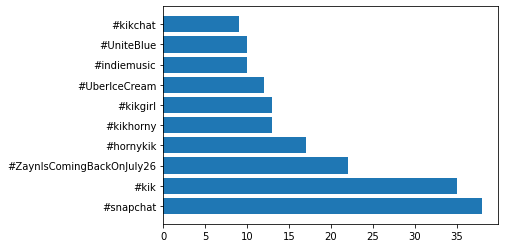

In [ ]:
# bar plot for negative
#find hashtags
hashlist = []
for tweet in df_neg['tweet']:
    for word in tweet.split():
        if (word.startswith('#')):
            hashlist.append(word)
#plot
hashtag, count = np.unique(hashlist, return_counts=True)
d3 = {'hashtag':hashtag,'count':count}
df3 = pd.DataFrame(data=d3)
df3 = df3.sort_values(by='count', ascending=False)
top10 = df3.head(10)
plt.barh(top10['hashtag'], top10['count'])
plt.show()


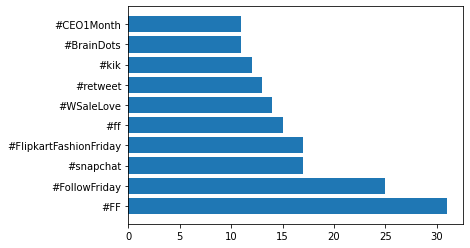

In [ ]:
# bar plot for positive
#find hashtags
hashlist = []
for tweet in df_pos['tweet']:
    for word in tweet.split():
        if (word.startswith('#')):
            hashlist.append(word)
#plot
hashtag, count = np.unique(hashlist, return_counts=True)
d3 = {'hashtag':hashtag,'count':count}
df3 = pd.DataFrame(data=d3)
df3 = df3.sort_values(by='count', ascending=False)
top10 = df3.head(10)
plt.barh(top10['hashtag'], top10['count'])
plt.show()

In the plots above, I have shown the top 10 hashtags for both negative and positive tweets.
For negative, there are: #snapchat, #kik, #ZaynIsComingBackOnJuly26, #hornykik, #kikhorny, #kikgirl, #UberIceCream #indiemusic #UniteBlue, and #kikchat.
For positive, there are: #FF, #FollowFriday, #snapchat, #FlipkartFashionFriday, #ff, #WSaleLove, #retweet, #kik, #BrainDots, and #CEO1Month.
From these 20 examples, most hashtags are not real words, and they don't show any sentiment in those words. Some of the hashtags such as #snapchat appear frequently in both negative and positive tweets. Also, different twitter users might have different opinions on the same topic.
Thus, I believe it is better to not include the hashtags in the sentiment analysis.

# Modelling

### Divide the dataset into 80% training set and 20% testing set. Perform three types of feature extraction techniques we have covered so far to the dataset for preparation. Clearly state what is the difference between these techniques and which one you expect would be the most appropriate.

In [ ]:
# divide the datatset
your_final_dataframe = shuffle(your_final_dataframe) #shuffle so that the positive and negative tweets are distributed randomly
trainX, testX, trainY, testY = train_test_split(your_final_dataframe, your_final_dataframe['sentiment'], test_size=0.2)
trainX_tidy, testX_tidy = trainX['tidy_tweet'].to_numpy(), testX['tidy_tweet'].to_numpy()
trainX_tknd, testX_tknd = trainX['tknd_tweet'].to_numpy(), testX['tknd_tweet'].to_numpy()
trainY, testY = trainY.to_numpy(), testY.to_numpy()

# feature extraction 1
#BoW
vectorizer1 = CountVectorizer()
#trainX_bow = vectorizer1.fit_transform(trainX['tidy_tweet'])
#testX_bow = vectorizer1.transform(testX['tidy_tweet'])
trainX_bow = vectorizer1.fit_transform(trainX_tidy)
testX_bow = vectorizer1.transform(testX_tidy)

# feature extraction 2
#TF-IDF
vectorizer2 = TfidfVectorizer()
#trainX_tfidf =vectorizer2.fit_transform(trainX['tidy_tweet'])
#testX_tfidf = vectorizer2.transform(testX['tidy_tweet'])
trainX_tfidf =vectorizer2.fit_transform(trainX_tidy)
testX_tfidf = vectorizer2.transform(testX_tidy)

# feature extraction 3
#Word2Vec
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
def word2vec(X):
    w2v=[]
    for sent in X:
        vector = np.zeros(300)
        for word in sent:
            if word in w2v_model:
                vector += w2v_model[word]
        w2v.append(vector)
    return w2v
trainX_w2v = word2vec(trainX_tknd)
testX_w2v = word2vec(testX_tknd)

#typecast outcome from sparse matrix to array
trainX_bow = trainX_bow.toarray()
testX_bow = testX_bow.toarray()
trainX_tfidf = trainX_tfidf.toarray()
testX_tfidf = testX_tfidf.toarray()

Clearly state what is the difference between these techniques and which one you expect would be the most appropriate:
Bow counts all the unique words in tweets and outputs a 2D array of word columns and tweet rows, each element containing the number of times the word appeared in the tweet. TF-IDF reflects the importance of the word in the tweet. TF-IDF is calculated by multiplying the TF value and the IDF value. TF value is how frequent the word is shown in the tweet, and IDF value shows how comon the word is among the many tweets. W2V adds up all the pre-trained vectors with size 300 and reflects the characteristics of each word.
BoW merely counts the words, and TF-IDF puts weight on counted words. On the other hand, since W2V considers the semantic meaning of the text, I am expecting W2V to be the most appropriate model in sentiment analysis.

### Use the sklearn package to implement KNN classifier models with difference number of neighbors. Please use three types of features above, and use the following metrics for comparing the performance: {accuracy, f1, precision, recall}. Write out how the metrics are calculated with formulas (or other ways). Plot the results using line chart, and suggest the best choice for this parameter.

In [ ]:
# KNN classifiers with different neighbors (1,2,3,4,... etc)
def knn_modeling (trainX, testX, trainY, testY):
    #initialise lists of performance metrics
    accuracy = []
    f1 = []
    precision = []
    recall = []

    #check for all k in range
    for k in range(50):
        #model
        knn_model = KNeighborsClassifier(n_neighbors = (k+1))
        knn_model.fit(trainX, trainY)
        predY = knn_model.predict(testX)
        #append performance metrics
        accuracy.append(accuracy_score(testY, predY))
        f1.append(f1_score(testY, predY))
        precision.append(precision_score(testY, predY))
        recall.append(recall_score(testY, predY))

    return accuracy, f1, precision, recall


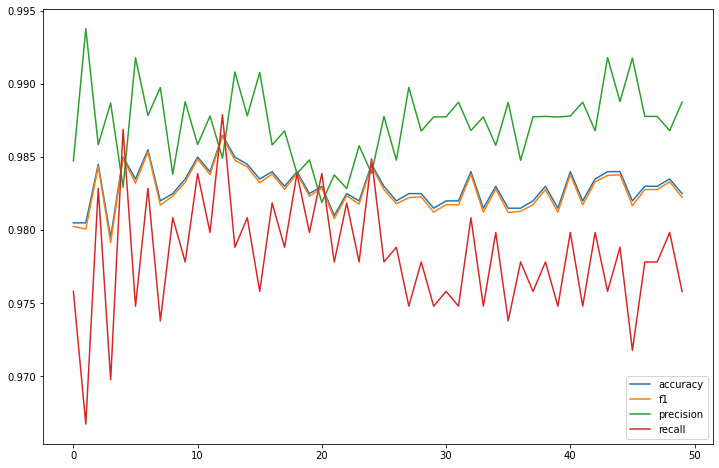

In [ ]:
#1. for BoW
accuracy, f1, precision, recall = knn_modeling(trainX_bow, testX_bow, trainY, testY)

# plot a line chart
plt.figure(figsize = (12, 8))
plt.plot(accuracy, label="accuracy")
plt.plot(f1, label="f1")
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.legend()
plt.show()

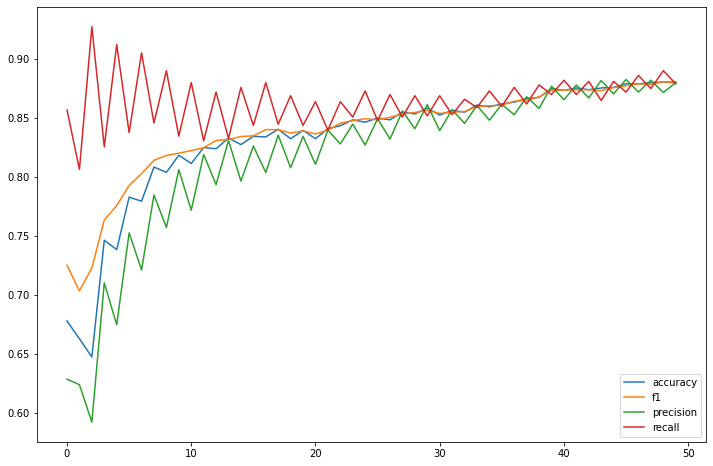

In [ ]:
#2. for TF-IDF
accuracy, f1, precision, recall = knn_modeling(trainX_tfidf, testX_tfidf, trainY, testY)

# plot a line chart
plt.figure(figsize = (12, 8))
plt.plot(accuracy, label="accuracy")
plt.plot(f1, label="f1")
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.legend()
plt.show()

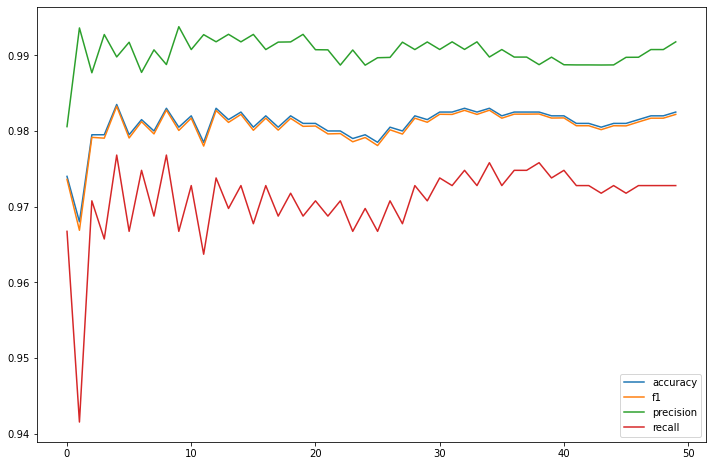

In [ ]:
#3. for W2V
accuracy, f1, precision, recall = knn_modeling(trainX_w2v, testX_w2v, trainY, testY)

# plot a line chart
plt.figure(figsize = (12, 8))
plt.plot(accuracy, label="accuracy")
plt.plot(f1, label="f1")
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.legend()
plt.show()

Write out how the metrics are calculated with formulas (or other ways):
1. accuracy = ((true positive) + (true negative)) / (all samples)
2. f1 = (2 * (precision) * (recall)) / ((precision) + (recall))
3. precision = (true positive) / ((true positive) + (false positive))
4. recall = (true positive) / ((true positive) + (false negative))

Suggest the best choice for this parameter:
1. for BoW, the four parameters meet at accurary 0.99 at k=100.
2. for TF-IDF, the four parameters meet at accuracy 0.95 at k=110.
3. for W2V, the four parameters peak at around k=10 and goes down slowly.
4. I would suggest the k = 11 since accuracy increases from k=10 to around k=11 but decreases after that, which I think is due to overfitting.

### Use the sklearn package to implement Naive Bayes classifier, Logistic regression, and KNN classifier. For KNN, you may directly use the best result above. Again use three types of features above, and use the following metrics for comparing the performance: {accuracy, f1, precision, recall}. Summarize the scores into tables and provide possible reasons that lead to this situation. Is the performance good? Why? (5 marks)

you should have $3*3*4=36$ outputs. When performing comparison, you could analyze from two views, one is comparing different feature extraction methods while model is the same, another is comparing different models when applying the same feature extraction procedure.

In [ ]:
# naive bayes classifier
def naive_bayes (trainX, testX, trainY, testY):
    nb_model = GaussianNB()
    nb_model.fit(trainX,trainY)
    predY = nb_model.predict(testX)
    #performance metrics
    accuracy = accuracy_score(testY, predY)
    f1 = f1_score(testY, predY)
    precision = precision_score(testY, predY)
    recall = recall_score(testY, predY)
    return accuracy, f1, precision, recall

# logistic regression
def logistic_regression (trainX, testX, trainY, testY):
    #model
    logistic_model = LogisticRegression()
    logistic_model.fit(trainX,trainY)
    predY = logistic_model.predict(testX)
    #performance metrics
    accuracy = accuracy_score(testY, predY)
    f1 = f1_score(testY, predY)
    precision = precision_score(testY, predY)
    recall = recall_score(testY, predY)
    return accuracy, f1, precision, recall

#knn classifier
def knn_classification (trainX, testX, trainY, testY):
    #model
    knn_model = KNeighborsClassifier(n_neighbors = 11)
    knn_model.fit(trainX, trainY)
    predY = knn_model.predict(testX)
    #performance metrics
    accuracy = accuracy_score(testY, predY)
    f1 = f1_score(testY, predY)
    precision = precision_score(testY, predY)
    recall = recall_score(testY, predY)
    return accuracy, f1, precision, recall

In [ ]:
#3D view

#Naive Bayes
accuracy, f1, precision, recall = naive_bayes(trainX_bow, testX_bow, trainY, testY)
BoW_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = naive_bayes(trainX_tfidf, testX_tfidf, trainY, testY)
tfidf_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = naive_bayes(trainX_w2v, testX_w2v, trainY, testY)
w2v_res = [accuracy, f1, precision, recall]

NB_res = [BoW_res, tfidf_res, w2v_res]


#Logistic Regression
accuracy, f1, precision, recall = logistic_regression(trainX_bow, testX_bow, trainY, testY)
BoW_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = logistic_regression(trainX_tfidf, testX_tfidf, trainY, testY)
tfidf_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = logistic_regression(trainX_w2v, testX_w2v, trainY, testY)
w2v_res = [accuracy, f1, precision, recall]

LR_res = [BoW_res, tfidf_res, w2v_res]


#KNN classifier
accuracy, f1, precision, recall = knn_classification(trainX_bow, testX_bow, trainY, testY)
BoW_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = knn_classification(trainX_tfidf, testX_tfidf, trainY, testY)
tfidf_res = [accuracy, f1, precision, recall]

accuracy, f1, precision, recall = knn_classification(trainX_w2v, testX_w2v, trainY, testY)
w2v_res = [accuracy, f1, precision, recall]

KNN_res = [BoW_res, tfidf_res, w2v_res]


#create dataframe
array_3d = xr.Dataset(
    {"Naive Bayes": (("Feature Extraction", "Result"), NB_res)},
    coords={
        "Feature Extraction": ["BoW", "TF-IDF", "Word2Vec"],
        "Result": ["accuracy", "f1", "precision", "recall"],
        "Logistic Regression": (("Feature Extraction", "Result"), LR_res),
        "KNN Classifier": (("Feature Extraction", "Result"), KNN_res),},)

df_3d = array_3d.to_dataframe()
print(df_3d)


                              Naive Bayes  Logistic Regression  KNN Classifier
Feature Extraction Result                                                     
BoW                accuracy      0.840000             0.989000        0.985000
                   f1            0.839840             0.989000        0.984864
                   precision     0.833996             0.981151        0.985859
                   recall        0.845766             0.996976        0.983871
TF-IDF             accuracy      0.816500             0.987000        0.811500
                   f1            0.815299             0.986895        0.822421
                   precision     0.814070             0.986895        0.771883
                   recall        0.816532             0.986895        0.880040
Word2Vec           accuracy      0.972000             0.987500        0.982000
                   f1            0.971660             0.987393        0.981689
                   precision     0.975610           

Summarize the scores into tables and provide possible reasons that lead to this situation.
1. comparing the feature extraction methods(BoW, TF-IDF, W2V), Word2Vec shows the highest accuracy among all. This is because unlike the other two methods, Word2Vec actually considers the semantic meaning of words when doing sentiment analysis.
2. comparing Naive Bayes, Logistic Regression, and KNN classifier, Logistic regression has the highest accuracy. On the other hand, Naive Bayes shows good accuracy but is the lowest among the three classifiers, and I belive this is due to the assumption that the probability of each word is indipendent.

Is the performance good? Why?
1. The performance is pretty good, since most of the parameters are higher than 90%. Among the classifiers, logistic regression is especially good and among the feature extraction methods, word2vec is expecially good, since it considers the semantic meaning of the words.

### Write out the procedure how naive bayes classifier is classifying our dataset. Remember to clearly write out the mathematical formulas involved in the procedure. Implement the naive bayes classifier step by step (without directly calling any package). Add clear explanations to your python code based on the procedure you stated above.

Naive Bayes procedure:
1. For the training, first calculate the mean and variance of features for each class
2. Then calculate the prior probability of each class. P(y) = (number of time the class shows up) / (total number of samples)
3. For prediction, we should first conpute the Gaussian Probabilities for each sample and each class. P(Xi|y) = 1 / (sqrt(2*pi*variance)) * exp(-(Xi - mean)^2 / (2 * variance))
4. Then compute the posterior.  posterior = P(x1|y) * P(x2|y) *...* P(x_n|y) * P(y) / P(X) = P(x1|y) * P(x2|y) *...* P(x_n|y) * P(y) = log(P(x1|y)) + log(P(x2|y) +...+ log(P(x_n|y) + log(P(y))
5. finanlly, get the argmax of y for each sample: decide whether each samples is classified to 0 or 1.

In [ ]:
# implement naive bayes based on the above procedure

#fit model
#training data
#set X, Y, n_features, n_samples, n_classes
X = np.array(trainX_w2v) #we will use the word2vec trainX data, since it has the highest accuracy
Y = trainY
n_samples, n_features = X.shape # n_samples=8000, n_samples=300
classes = np.array([0,1]) #2 classes: 0=negatice, 1=positive
n_classes = 2

#calculate statistics: mean, variance, prior
mean = np.zeros((n_classes, n_features)) #initialise mean
variance = np.zeros((n_classes, n_features)) #initialise variance
for i in classes:
    X_i = X[Y==i]
    mean[i,:] = X_i.mean(axis=0) #calculate mean of features for each class
    variance[i,:] = X_i.var(axis=0) #calculate variance of features for each class

#calculate the prior probability of each class
prior = np.zeros(2)
for i in classes:
    count = sum(trainY == i)
    prior[i] = count / n_samples


#prediction
#test data
X = np.array(testX_w2v)
n_samples, n_features = X.shape # n_samples=2000, n_samples=300

#compute Gaussian
#Gaussian Probabilities for each sample and each class
#P(Xi|y) = 1 / (sqrt(2*pi*variance)) * exp(-(Xi - mean)^2 / (2 * variance))
gaussian = np.zeros((n_classes, n_samples, n_features))
for idx in classes:
    i = 0
    for x in X:
        numerator = np.exp((-(x-mean[idx])**2) / (2 * variance[idx]))
        denominator = np.sqrt(2 * np.pi * variance[idx])
        gaussian_prob = numerator / denominator
        gaussian[idx][i] = gaussian_prob
        i += 1

#compute posterior
#posterior = P(x1|y) * P(x2|y) *...* P(x_n|y) * P(y) / P(X)
#          = P(x1|y) * P(x2|y) *...* P(x_n|y) * P(y)
#          = log(P(x1|y)) + log(P(x2|y) +...+ log(P(x_n|y) + log(P(y))
posterior = np.zeros((n_classes, n_samples))
for idx in classes:
    i = 0
    for x in X:
        posterior[idx,i] = np.sum(np.log(gaussian[idx,i])) + np.log(prior[idx]) #posterior for each sample and each class
        i += 1

#find argmax for each sample: decide whether each samples is classified to 0 or 1.
prediction = np.zeros(n_samples)
i = 0
for x in X:
    prediction[i] = np.argmax(posterior[:,i]) #argmax of each sample -> 0 or 1
    i += 1

# get accuracy, f1, precision, recall to evaluate the classification result
accuracy = accuracy_score(testY, prediction)
f1 = f1_score(testY, prediction)
precision = precision_score(testY, prediction)
recall = recall_score(testY, prediction)
print("accuracy: ", accuracy)
print("f1: ", f1)
print("precision: ", precision)
print("recall: ", recall)

accuracy:  0.972
f1:  0.97165991902834
precision:  0.975609756097561
recall:  0.967741935483871


1. The accuracy, f1, precision, and recall for W2V features are exactly the same with the one in Q4-3. The method in Q4-3 and in Q4-4 were both gaussian naive bayes, so they give out identical results.




### Write out the procedure how logistic regression is working in our case. Remember to clearly write out the mathematical formulas involved in the procedure. Implement the logistic regression using Stochastic Gradient Descent (SGD) step by step (without directly calling any package). Add clear explanations to your python code based on the procedure you stated above. Compare the results you get here with the one in Q4-3. (15 marks)

Logistic regression procedure:
1. For the training part, first run an n-iteration for loop to perform gradient descent.
2. Inside the for loop, first perform predictions. z = wX + b
3. Then apply the sigmoid function to z. y_hat = sigmoid(z) = 1 / (1 + exp(-z))
4. Then get the gradients of loss for weights and bias:
    1) gradient for weights: dw = (1 / n_samples) * np.dot(X.T, (y_hat - Y))
    2) gradient for bias: db = (1 / n_samples) * np.sum((y_hat - Y))
5. Then update weights and bias:
    1) weight = weight - learning_rate * dw
    2) bias = bias - learning_rate * db

6. For the prediction part, first get predictions of the test set. z = wX + b
7. Then apply the sigmoid function to z. y_hat = sigmoid(z) = 1 / (1 + exp(-z))
8. classify according to probability. since y is the probability that the prediction is 1, set prediction as 1 if y>0.5 and 0 if y<=0.5.

In [ ]:
# implement logistic regression based on the above procedure

#fit model
#training data
#set X, Y, n_features, n_samples
X = np.array(trainX_w2v) #we will use the word2vec trainX data, since it has the highest accuracy
Y = trainY
n_samples, n_features = X.shape # n_samples=8000, n_samples=300

#set weight, bias, number of iterations, and learning rate
weight = np.zeros(n_features) #set weight
bias = 0 #set bias
n_iter = 1000 #set number of iterations
learning_rate = 0.1 #set learning rate

#stochastic gradient descent
#perform for loop n times for gradient descent to find the best weight and bias

for i in range (n_iter):
    #perform predictions
    z= np.dot(X, weight) + bias # z = wX + b
    y_hat = 1 / (1 + np.exp(-z)) # y_hat = sigmoid(z)

    #get gradients of loss for weights and bias
    dw = (1 / n_samples) * np.dot(X.T, (y_hat - Y)) #gradient for weights
    db = (1 / n_samples) * np.sum((y_hat - Y)) #gradient for bias

    #perform steps of gradient descent
    weight = weight - learning_rate * dw
    bias = bias - learning_rate * db


#prediction
#test data
X = np.array(testX_w2v)
n_samples, n_features = X.shape # n_samples=2000, n_samples=300

#get prediction probabilities
z= np.dot(X, weight) + bias # z = wX + b
y_hat = 1 / (1 + np.exp(-z)) # y_hat = sigmoid(z)

#classify according to probability
#since y is the probability that the prediction is 1,
#set prediction as 1 if y>0.5 and 0 if y<=0.5.
prediction = np.zeros(n_samples)
idx = 0
for y in y_hat:
    if (y > 0.5):
        prediction[idx] = 1
    else:
        prediction[idx] = 0
    idx+= 1

# get accuracy, f1, precision, recall to evaluate the classification result
accuracy = accuracy_score(testY, prediction)
f1 = f1_score(testY, prediction)
precision = precision_score(testY, prediction)
recall = recall_score(testY, prediction)
print("accuracy: ", accuracy)
print("f1: ", f1)
print("precision: ", precision)
print("recall: ", recall)

accuracy:  0.9895
f1:  0.9894419306184012
precision:  0.9869608826479438
recall:  0.9919354838709677


 Compare the results you get here with the one in Q4-3:
 The performance results for my implementation of logistic regression is quite similar to the results above. However, accuracy and recall is slightly higher and f1 and precision is slightly lower. The slight differences could be due to different n iternations and learning rate than what I used.